<a href="https://colab.research.google.com/github/iamsusmita/css-course-content/blob/master/blank_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1Ibo9CUpi7NmDflUfw1y611chvOLcE22x')

     |████████████████████████████████| 71kB 6.6MB/s 


In [2]:
!pip install jovian --upgrade --quiet

In [3]:
project_name='Flowers-Identification'

## For this course project, I have picked Flowers dataset from Kaggle.
https://www.kaggle.com/alxmamaev/flowers-recognition

### Download the dataset in notebook

In [4]:
!pip install opendatasets --upgrade --quiet

In [5]:
dataset_url='https://www.kaggle.com/alxmamaev/flowers-recognition'

In [6]:
import opendatasets as od
import os
import numpy as np
import shutil

In [7]:
if os.path.exists('./flowers-recognition'):
  shutil.rmtree('./flowers-recognition')

In [8]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sinfomedia
Your Kaggle Key: ··········


  2%|▏         | 9.00M/450M [00:00<00:05, 84.9MB/s]

100%|██████████| 450M/450M [00:01<00:00, 246MB/s]


In [9]:
data_dir='./flowers-recognition/flowers'

In [10]:
os.listdir(data_dir)

['flowers', 'dandelion', 'rose', 'daisy', 'sunflower', 'tulip']

In [11]:
shutil.rmtree(data_dir+'/flowers')

In [12]:
os.listdir(data_dir)

['dandelion', 'rose', 'daisy', 'sunflower', 'tulip']

In [13]:
from torchvision.datasets import ImageFolder

In [14]:
dataset=ImageFolder(data_dir)

In [15]:
len(dataset)

4323

In [16]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7FB68295A8D0>, 0)

Flowers dataset pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion. 
Each class has around 700 -1000 images

In [17]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [18]:
for cls in os.listdir(data_dir):
  print(cls, len(os.listdir(data_dir+'/'+cls)))

dandelion 1055
rose 784
daisy 769
sunflower 734
tulip 984


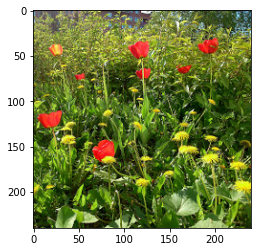

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
img, label = dataset[1000]
plt.imshow(img)

In [20]:
import torchvision.transforms as tt

In [21]:
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                           tt.RandomCrop(64),
                                           tt.ToTensor()]))

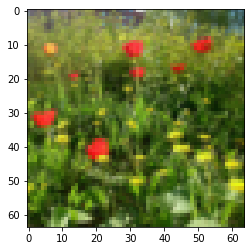

In [22]:
img, label = dataset[1000]
plt.imshow(img.permute(1,2,0))

### Let's split dataset into Training Dataset and Validation Dataset.

In [23]:
val_pct=0.1
val_size=int(val_pct * len(dataset))
train_size= len(dataset)-val_size

train_size, val_size


(3891, 432)

In [24]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3891, 432)

In [25]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [26]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

In [27]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

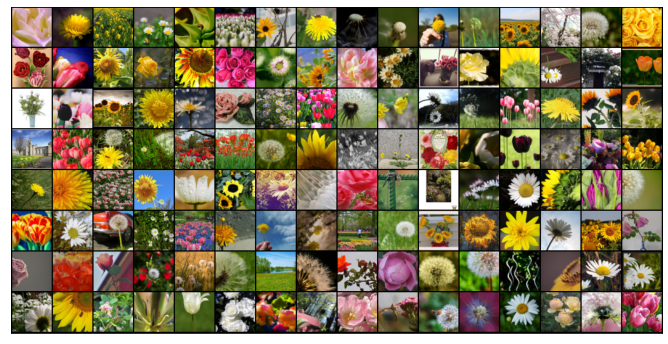

In [28]:
show_batch(train_dl)

# GPU Utilities

In [29]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
device = get_default_device()
device

device(type='cuda')

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Model and Training Utilities

In [32]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [33]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [34]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/iamsusmita/flowers-identification


'https://jovian.ai/iamsusmita/flowers-identification'

### Let's create a Model
# ResNet9 Model

In [35]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), 
                                  conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), 
                                  conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [36]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [37]:
model.conv1[0].weight.device

device(type='cuda', index=0)

### Test Model for one batch

In [38]:
torch.cuda.empty_cache()
for batch in train_dl:
  img, labels= batch
  print('img.shape',img.shape)
  print('img.device',img.device)
  preds = model(img)
  print('preds.shape',preds.shape)
  break

img.shape torch.Size([128, 3, 64, 64])
img.device cuda:0
preds.shape torch.Size([128, 5])


## Train the Model

In [39]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.1881510466337204, 'val_loss': 1.6088979244232178}]

In [40]:
epochs = 8
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [41]:
%%time
history += fit(epochs, max_lr, model, train_dl, val_dl, 
                             opt_func=opt_func)

Epoch [0], train_loss: 1.4844, val_loss: 2.6220, val_acc: 0.2103
Epoch [1], train_loss: 0.9387, val_loss: 0.8436, val_acc: 0.6660
Epoch [2], train_loss: 0.8237, val_loss: 0.8041, val_acc: 0.6992
Epoch [3], train_loss: 0.6965, val_loss: 0.7175, val_acc: 0.7520
Epoch [4], train_loss: 0.6282, val_loss: 0.7177, val_acc: 0.7298
Epoch [5], train_loss: 0.5592, val_loss: 0.8005, val_acc: 0.6979
Epoch [6], train_loss: 0.5140, val_loss: 0.6618, val_acc: 0.7428
Epoch [7], train_loss: 0.4963, val_loss: 0.8421, val_acc: 0.6751
CPU times: user 7.65 s, sys: 5.24 s, total: 12.9 s
Wall time: 1min 27s


In [42]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

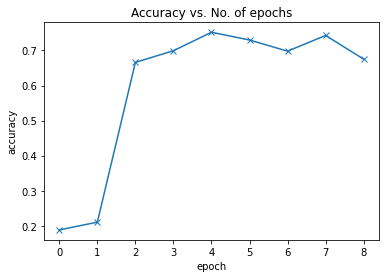

In [43]:
plot_accuracies(history)

In [44]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

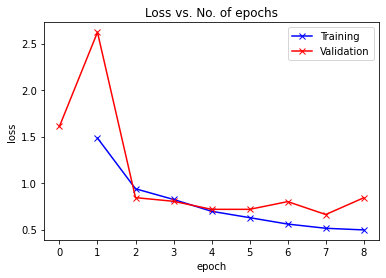

In [45]:
plot_losses(history)

In [46]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [53]:
%%time
history += fit(5, max_lr, model, train_dl, val_dl, 
                             opt_func=opt_func)

Epoch [0], train_loss: 0.5320, val_loss: 0.7287, val_acc: 0.7500
Epoch [1], train_loss: 0.4609, val_loss: 0.7629, val_acc: 0.7311
Epoch [2], train_loss: 0.3750, val_loss: 0.6268, val_acc: 0.7865
Epoch [3], train_loss: 0.3377, val_loss: 0.5553, val_acc: 0.7956
Epoch [4], train_loss: 0.3089, val_loss: 0.5968, val_acc: 0.7930
CPU times: user 4.8 s, sys: 3.46 s, total: 8.26 s
Wall time: 53.8 s


In [48]:
jovian.reset()
jovian.log_dataset(img_size=64)
jovian.log_hyperparams(batch_size=128)
jovian.log_metrics(epoch=epochs,
    train_loss=history[-1]['train_loss'],
    val_loss=history[-1]['val_loss'],
    val_acc=history[-1]['val_acc'],
    )

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [49]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/iamsusmita/flowers-identification


'https://jovian.ai/iamsusmita/flowers-identification'

### Now Testing Time!!!

In [50]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

Source: rose
Prediction: rose


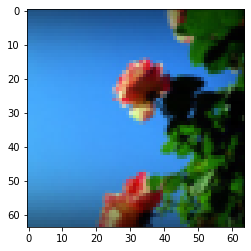

In [54]:
img, label = val_ds[87]
plt.imshow(img.permute(1,2,0))
pred = predict_image(img,model,dataset.classes)
print('Source:', dataset.classes[label])
print('Prediction:', pred)

In [52]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/iamsusmita/flowers-identification


'https://jovian.ai/iamsusmita/flowers-identification'

# THANK YOU!!!